# Сегментация изображений





---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>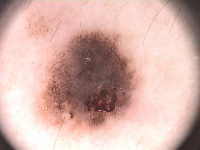</td><td>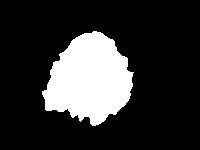</td></tr></table>


In [ ]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2021-05-14 11:45:05--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2021-05-14 11:45:05--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8270a17179b00fd041299383db.dl.dropboxusercontent.com/cd/0/inline/BOfGeGQKufUsfgPDePGKI5RLYHuYQ8R3_g3SbDmzVzYnEAjNWGrSQPoBCBk7edWPQHlB29npY5UaJfEX-LzNyWeQ17DD4wDEG3H4HjdNq4hrkBzoJj_7cnjtcSou2hTPvIXTURBgN2GsU7BXc3Jrn4ew/file# [following]
--2021-05-14 11:45:06--  https://uc8270a17179b00fd041299383db.dl.dropboxusercontent.com/cd/0/inline/BOfGeGQKufUsfgPDePGKI5RLYHuYQ8R3_g3SbDmzVzYnEAjNWGrSQPoBCBk7edWPQHlB29npY5UaJfEX-

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

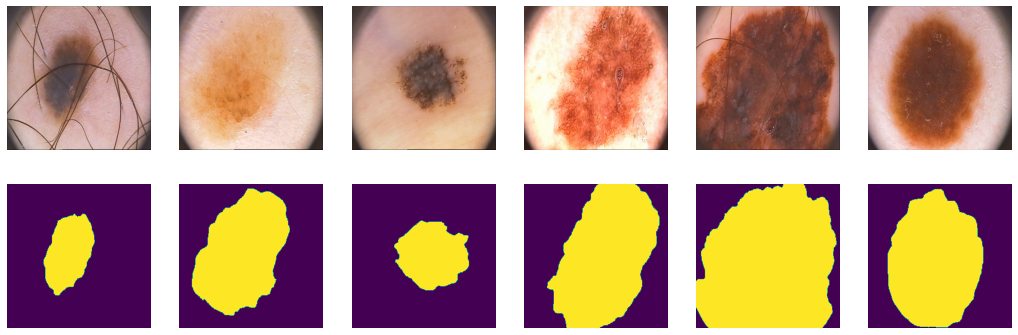

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

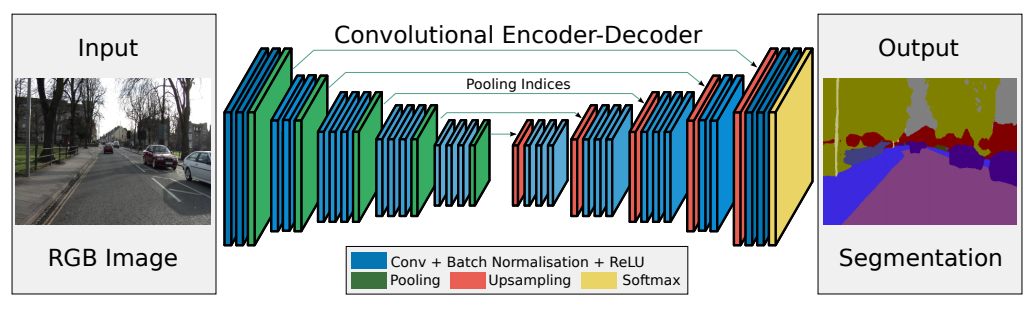

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                              nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.enc_conv1 = nn.Sequential(
                              nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.enc_conv2 = nn.Sequential(
                              nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )     
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.enc_conv3 = nn.Sequential(
                              nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              
                              nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              
                              nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        #----------------------------------------------------------------------------------------------------------------------------
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True),
                                    
                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True),
                                    
                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True),

                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),


                                    nn.Upsample(scale_factor=2), # 16 -> 32

                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True),
                                    
                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True),
                                    
                                    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                    nn.ReLU(inplace=True)
        )

        #----------------------------------------------------------------------------------------------------------------------------
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                              nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              
                              nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              
                              nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )

        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                              nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )

        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                              nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True)
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(3),
                              nn.ReLU(inplace=True),

                              nn.Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
        )

        self.activation = nn.Sigmoid()

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation

        a = self.activation(d3)
        return a

## Метрика


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = (outputs>0.5).squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это логистическая* функция, который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее упрощение. Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):#loss(y_pred, y_real)
    loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

    return loss

In [ ]:
Y[tr].size

6553600

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    X_val, Y_val = next(iter(data_val))
    
    losses = {"train": [],
              "val": []}
    best_loss = np.inf
    best_model_wts = model.state_dict()

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            
            running_loss, processed_data = 0, 0

            model = model.to(device)
            opt.zero_grad()
            
            if phase=="train":
                tic = time()
                
                for X_batch, Y_batch in data_tr:
                    # data to device
                    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

                    optimizer.zero_grad()
                    Y_pred = model(X_batch).to(device)
                
                    # forward
                    loss = loss_fn(Y_pred, Y_batch) # forward-pass
              
                    loss.backward()  # backward-pass
                    opt.step()  # update weights

                    running_loss += loss.item() * X_batch.size(0)
                    processed_data += X_batch.size(0)
                
                toc = time()

                # calculate loss to show the user
                avg_loss = running_loss / processed_data
                losses[phase].append(avg_loss)
                print('train loss: %f' % avg_loss)
                scheduler.step()
            elif phase == 'val':
                with torch.no_grad():
                   Y_hat = model(X_val.to(device)) # detach and put into cpu
                epoch_loss = loss_fn(Y_hat, Y_val.to(device))
                losses[phase].append(epoch_loss)
                print('val loss: %f' % epoch_loss)
            
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()

                # Visualize tools
                clear_output(wait=True)
                Y_hat = Y_hat.detach().cpu()
                fig, axes = plt.subplots(ncols=4, nrows=2)

                for k in range(4):
                    axes[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                    axes[0, k].set_title('Real')
                    axes[0, k].axis('off')
                    
                    axes[1, k].imshow(Y_hat[k, 0], cmap='gray')
                    axes[1, k].set_title('Output')
                    axes[1, k].axis('off')
                fig.suptitle(f'epoch: {epoch}; loss: {avg_loss}')
                plt.show()

    model.load_state_dict(best_model_wts)

    return model, losses

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, X_batch):
    model.eval()  # testing mode
    model = model.cpu()
    Y_pred = model(X_batch).detach()
    #Y_pred = model(X_batch)
    return Y_pred > 0.5

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Обучение



In [ ]:
model_segnet = SegNet().to(device)

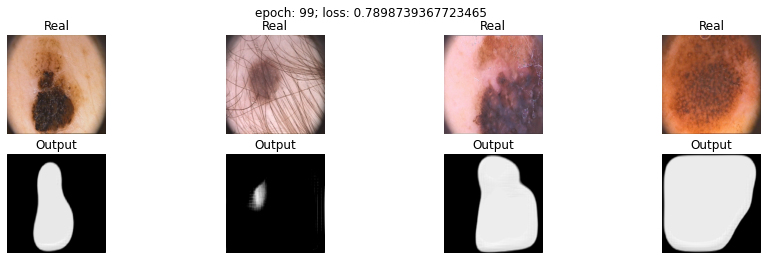

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model_segnet.parameters(), lr=1e-4) 
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_segnet_bce, losses_segnet_bce = train(model_segnet, optimizer, bce_loss, max_epochs, data_tr, data_val, exp_lr_scheduler)

In [ ]:
while True:
  pass

KeyboardInterrupt: ignored

In [ ]:
torch.save(model_segnet_bce.state_dict(), 'BCE_Segnet.pth')

In [ ]:
model.load_state_dict(torch.load('BCE_Segnet.pth'))

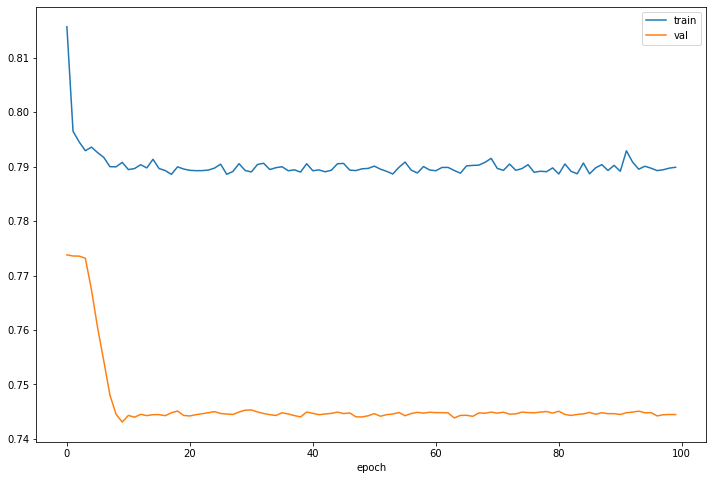

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_bce['train'], label="train")
plt.plot(losses_segnet_bce['val'], label="val")
plt.legend()
plt.xlabel("epoch")
plt.show()

In [ ]:
score_model(model_segnet_bce, iou_pytorch, data_ts)

0.508333332836628

In [ ]:
def demo_test(model):
    X_test_batch, Y_test_batch = next(iter(data_ts))
    P_test_batch = predict(model, X_test_batch)

    fig, axes = plt.subplots(ncols=15, nrows=2, figsize=(20, 4), constrained_layout=True)

    for k in range(15):
        axes[0, k].imshow(Y_test_batch[k, 0], cmap='gray')
        axes[0, k].set_title('Real')
        axes[0, k].axis('off')
        
        axes[1, k].imshow(P_test_batch[k, 0], cmap='gray')
        axes[1, k].set_title('Output')
        axes[1, k].axis('off')

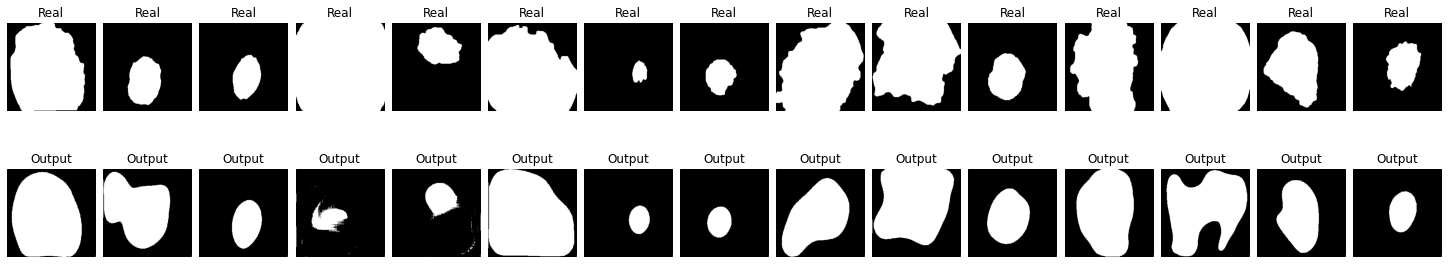

In [ ]:
demo_test(model_segnet_bce)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$




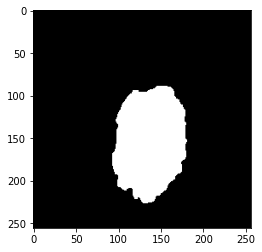

In [ ]:
X_val, Y_val = next(iter(data_val))
plt.imshow(Y_val[0, 0], cmap='gray')

In [ ]:
Y_val[0].shape

torch.Size([1, 256, 256])

In [ ]:
def dice_loss(y_real, y_pred):
    epsilon = 10e-10
    res = 1 - torch.sum(2*y_real*y_pred/(y_real+y_pred+epsilon)) / (256*256)
    return res 

In [ ]:
dice_loss(Y_val[0], Y_val[0])

tensor(0.8594)

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

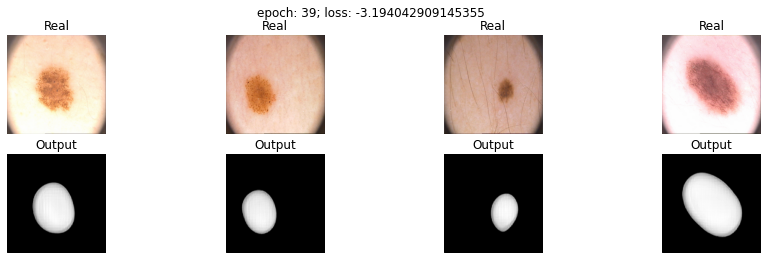

In [ ]:
max_epochs = 40
optimizer = optim.Adam(model_dice.parameters(), lr=1e-4) 
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_segnet_dice, losses_segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, exp_lr_scheduler)

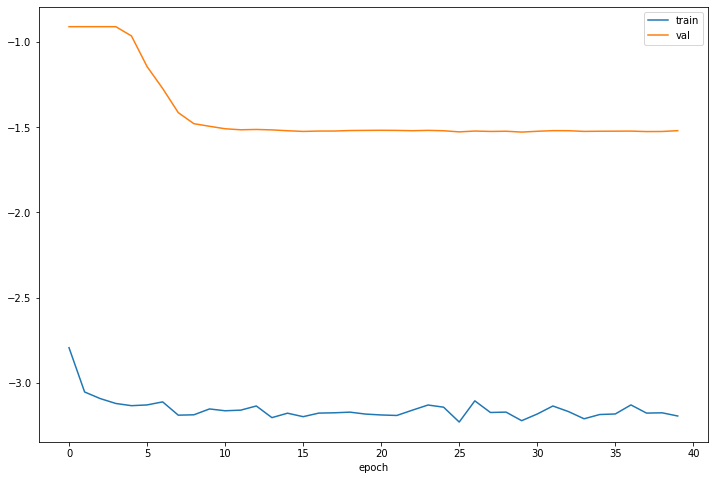

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_dice['train'], label="train")
plt.plot(losses_segnet_dice['val'], label="val")
plt.legend()
plt.xlabel("epoch")
plt.show()

In [ ]:
score_model(model_segnet_dice, iou_pytorch, data_ts)

0.6683333367109299

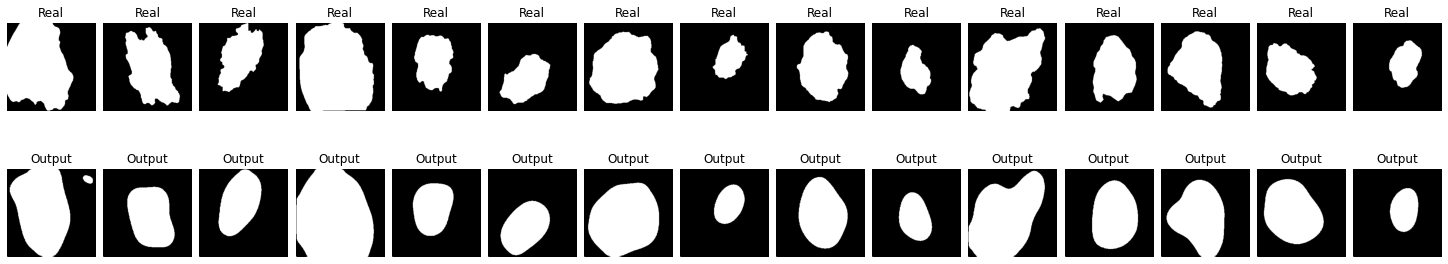

In [ ]:
demo_test(model_segnet_dice)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу большинства (фоновому) по отношению к классу меньшинства ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    loss = - torch.mean((1 - y_pred)**gamma * y_real * torch.log(y_pred + eps) \
                          + (1-y_real)*torch.log(1 - y_pred + eps)) # hint: torch.clamp
    return loss


In [ ]:
model_focal = SegNet().to(device)

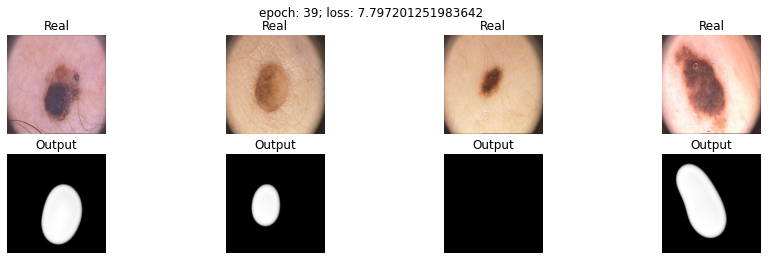

In [ ]:
max_epochs = 40
optimizer = optim.Adam(model_focal.parameters(), lr=1e-2)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_segnet_focal, losses_segnet_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, exp_lr_scheduler)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.4716666638851166

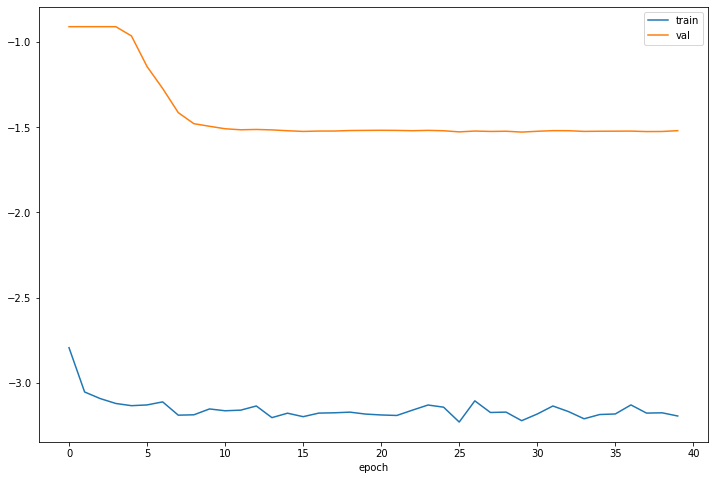

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_dice['train'], label="train")
plt.plot(losses_segnet_dice['val'], label="val")
plt.legend()
plt.xlabel("epoch")
plt.show()

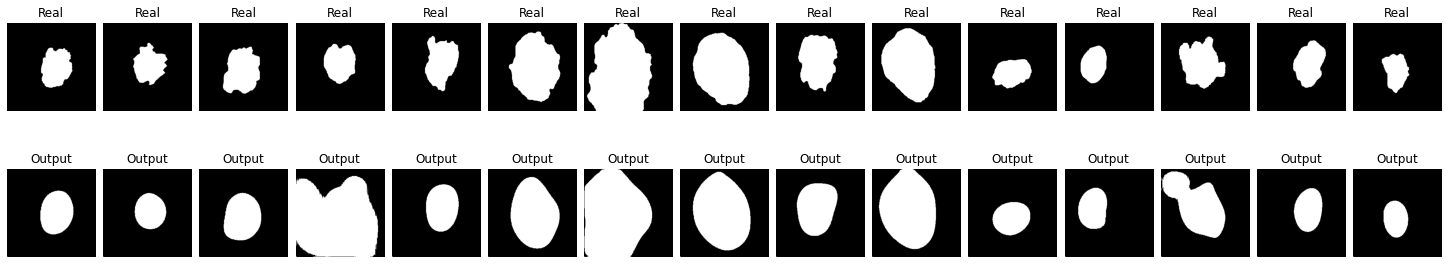

In [ ]:
demo_test(model_segnet_dice)

-----------------------------------------------------------------------------------------

# U-Net 

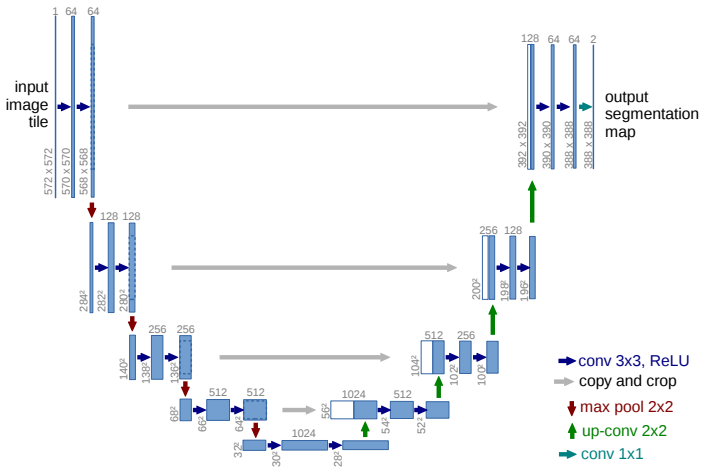

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                                       nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
                                       nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
                                       nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
                                       nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                             nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                             nn.ReLU(inplace=True)
                                            )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                       nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64  
        self.dec_conv1 = nn.Sequential(
                                       nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )
      
        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                       nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True)
                                      )

        self.upsample3 = nn.Upsample(scale_factor=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                       nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
                                      )
        
        self.activation = nn.Sigmoid()


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        #print("e0: ", e0.shape)
        e1 = self.enc_conv1(self.pool0(e0))
        #print("e1: ", e1.shape)
        e2 = self.enc_conv2(self.pool1(e1))
        #print("e2: ", e2.shape)
        e3 = self.enc_conv3(self.pool2(e2))
        #print("e3: ", e3.shape)
        
        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))
        #print("b: ", b.shape)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b)[:,512:], e3), 1))
        #print("d0: ", d0.shape)
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0)[:,256:],e2), 1))
        #print("d1: ", d1.shape)
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1)[:,128:],e1), 1))
        #print("d2: ", d2.shape)
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2)[:,64:],e0), 1))
        #print("d3: ", d3.shape)

        #a = self.activation(d3)
        return d3

In [ ]:
unet_model = UNet().to(device)

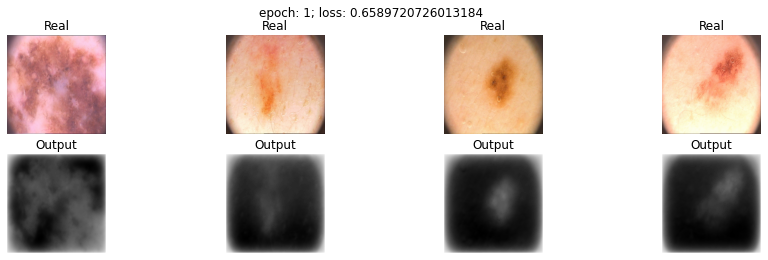

In [ ]:
max_epochs = 20
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4) 
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

unet_model, unet_losses = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val, exp_lr_scheduler)

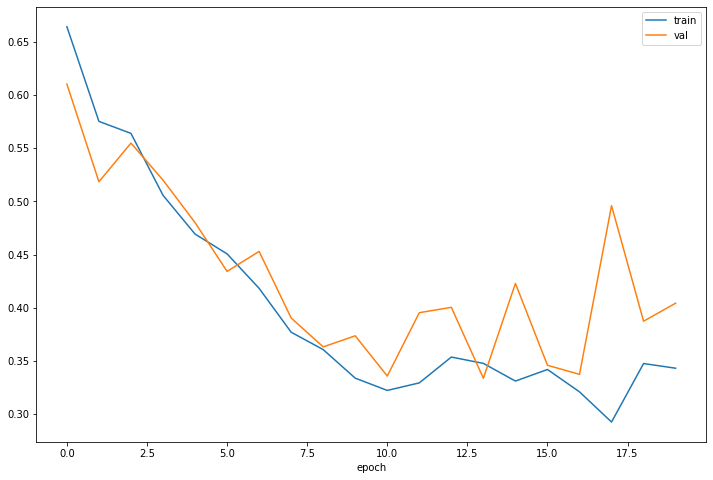

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(unet_losses['train'], label="train")
plt.plot(unet_losses['val'], label="val")
plt.legend()
plt.xlabel("epoch")
plt.show()

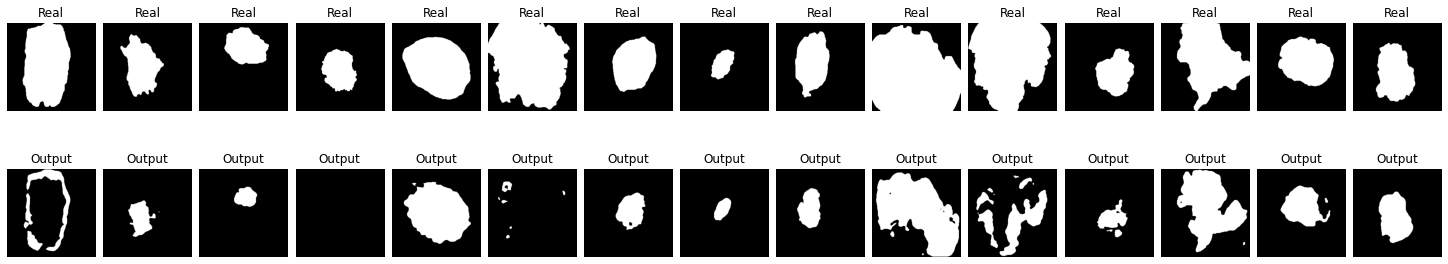

In [ ]:
demo_test(unet_model)

In [1]:
# модель явно может работать лучше, но способа это сделать, на момент написания ноутбука я не нашел